In [1]:
%pip install -q --upgrade sentence-transformers
%pip install -q --upgrade faiss-cpu
%pip install -q --upgrade faiss-gpu
%pip install -q --upgrade scikit-learn
%pip install -q --upgrade pandas
%pip install -q --upgrade numpy
%pip install -q --upgrade matplotlib
import pandas as pd
from sklearn.ensemble import IsolationForest
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split
import os
import faiss
from sklearn.neighbors import LocalOutlierFactor

warnings.filterwarnings("ignore")
ANOMALY_LABELS = ["is_fraud"]
BINARY_LABEL = "is_fraud"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Users\orric\python_projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Choose between OpenAI or AzureOpenAI
USE_AZURE = False  # Set to True if running experiments at work

if USE_AZURE:
    from openai import AzureOpenAI
    client = AzureOpenAI(
        azure_endpoint="PUT ENDPOINT HERE",
        api_key="PUT API KEY HERE",
        api_version="PUT VERSION HERE"
    )
    deployment_name = "PUT DEPLOYMENT NAME HERE"
else:
    import openai
    client = openai.OpenAI(api_key="PUT CHATGPT API KEY HERE")  # Replace with your actual key or set as env var
    deployment_name = "gpt-4o"


## 📦 Dataset Loader and Preprocessing

This section defines functions for:
- Loading different fraud-related datasets
- Splitting into train/test sets
- Balancing the data for anomaly detection (important since fraud is rare!)


In [9]:
# === Dataset Loader + Test ===

def load_dataset(name):
    """
    Loads dataset based on name and updates anomaly label type.
    Returns: dataframe, domain name
    """
    global ANOMALY_LABELS

    if name == "credit":
        df = pd.read_csv("creditcard.csv", index_col=0)
        domain = "credit"
        ANOMALY_LABELS = ["Class"]
    elif name == "insurance":
        df = pd.read_csv("my_data/insurance2.csv", index_col=0)
        domain = "insurance"
        ANOMALY_LABELS = ["is_fraud"]
    elif name == "fraudtest":
        df = pd.read_csv("fraudTest.csv", index_col=0)
        domain = "fraudtest"
        ANOMALY_LABELS = ["is_fraud"]
    else:
        raise ValueError(f"❌ Unknown dataset: {name}")
    
    print(f"📄 Loaded dataset: '{name}' | Domain: {domain} | Shape: {df.shape}")
    print(f"🔎 Anomaly label column: {ANOMALY_LABELS[0]}")
    return df, domain

# === Run a test load on "fraudtest" dataset ===
df, domain = load_dataset("insurance")

# Show a preview of the data
print("\n🔍 Sample data:")
display(df.head())


📄 Loaded dataset: 'insurance' | Domain: insurance | Shape: (1338, 7)
🔎 Anomaly label column: is_fraud

🔍 Sample data:


,sex,bmi,children,smoker,region,charges,insuranceclaim
age,,,,,,,
19,0,27.900,0,1,3,16884.92400,1
18,1,33.770,1,0,2,1725.55230,1
28,1,33.000,3,0,2,4449.46200,0
33,1,22.705,0,0,1,21984.47061,0
32,1,28.880,0,0,1,3866.85520,1


In [11]:
# Convert insuranceclaim to is_fraud (inverse logic)
df['is_fraud'] = df['insuranceclaim'].apply(lambda x: 0 if x == 1 else 1)

# Drop the original insuranceclaim column
df.drop(columns=['insuranceclaim'], inplace=True)

# Sanity check
print(df['is_fraud'].value_counts())
df.head()



KeyError: 'insuranceclaim'

In [13]:
# === Define and run preprocessing function ===

def preprocess_data_train_test(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Splits the data into train/test sets and balances each subset.
    Balancing is done by undersampling the majority class.
    """
    print("🧪 Splitting dataset into train/test...")
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    print(f"→ Train shape: {train_df.shape}, Test shape: {test_df.shape}")

    def balance_data(df_subset: pd.DataFrame) -> pd.DataFrame:
        print(f"⚖️ Balancing on: {ANOMALY_LABELS[0]}")
        fraud = df_subset[df_subset[ANOMALY_LABELS[0]] == 1]
        non_fraud = df_subset[df_subset[ANOMALY_LABELS[0]] == 0]

        if len(fraud) == 0:
            raise ValueError("❌ No fraud samples found — cannot balance.")
        if len(non_fraud) < len(fraud):
            raise ValueError("❌ Not enough non-fraud samples to balance.")

        non_fraud_balanced = non_fraud.sample(n=len(fraud), random_state=random_state)
        balanced_df = pd.concat([fraud, non_fraud_balanced]).sample(frac=1, random_state=random_state).reset_index(drop=True)

        print(f"✔️ Balanced to {len(balanced_df)} rows: {len(fraud)} fraud / {len(non_fraud_balanced)} non-fraud")
        return balanced_df

    return balance_data(train_df), balance_data(test_df)

# === Apply preprocessing on the loaded dataset ===
train_df, test_df = preprocess_data_train_test(df)

# Show class distribution
print("\n📊 Class distribution in TRAIN:")
print(train_df[ANOMALY_LABELS[0]].value_counts())

print("\n📊 Class distribution in TEST:")
print(test_df[ANOMALY_LABELS[0]].value_counts())

# Optional: peek at the first few rows
print("\n🔍 Sample from balanced train set:")
display(train_df.head())


🧪 Splitting dataset into train/test...
→ Train shape: (1070, 7), Test shape: (268, 7)
⚖️ Balancing on: is_fraud
✔️ Balanced to 896 rows: 448 fraud / 448 non-fraud
⚖️ Balancing on: is_fraud
✔️ Balanced to 214 rows: 107 fraud / 107 non-fraud

📊 Class distribution in TRAIN:
is_fraud
0    448
1    448
Name: count, dtype: int64

📊 Class distribution in TEST:
is_fraud
1    107
0    107
Name: count, dtype: int64

🔍 Sample from balanced train set:


,sex,bmi,children,smoker,region,charges,is_fraud
0,1,33.880,0,1,2,46889.26120,0
1,0,19.475,2,0,1,6933.24225,1
2,0,28.120,1,1,0,22331.56680,0
3,1,27.360,3,0,0,8606.21740,0
4,0,37.335,2,0,1,5989.52365,1


# 🧬 Feature Embedding

This section transforms structured data into dense numeric vectors (embeddings) that can be compared and clustered.

We:
- Identify numeric vs. textual columns
- Scale numeric data using `StandardScaler`
- Embed any text columns using a pretrained transformer (e.g. `all-MiniLM-L6-v2`)
- Combine everything into one high-dimensional feature matrix

This enables us to later compute similarity between transactions and find meaningful precedent cases.


In [14]:
# === Define and run feature embedding preprocessing ===

def preprocess_data_LP(train_df):
    """
    Prepares training embeddings:
    - Scales numerical features
    - Embeds textual features using SentenceTransformer
    - Returns combined embedding matrix + metadata
    """
    train_df_features = train_df.drop(columns=ANOMALY_LABELS, errors="ignore")

    # Identify feature types
    numeric_cols = train_df_features.select_dtypes(include=["number"]).columns.tolist()
    text_cols = [col for col in train_df_features.columns if col not in numeric_cols]

    print(f"🔢 Numeric columns: {numeric_cols}")
    print(f"📝 Text columns: {text_cols if text_cols else 'None'}")

    # Scale numeric
    scaler = StandardScaler()
    numeric_train = scaler.fit_transform(train_df_features[numeric_cols])

    # Embed text (if any)
    if text_cols:
        model = SentenceTransformer("all-MiniLM-L6-v2")
        train_df_features["combined_text"] = train_df_features[text_cols].astype(str).agg(" ".join, axis=1)
        print(f"✍️ Sample combined text:\n{train_df_features['combined_text'].iloc[0][:150]}...")

        text_train = model.encode(train_df_features["combined_text"].tolist(), show_progress_bar=True)
        train_embeddings = np.hstack([numeric_train, text_train])
    else:
        model = None
        train_embeddings = numeric_train

    print(f"\n✅ Final embedding shape: {train_embeddings.shape}")
    print("🔍 Sample row from embeddings:")
    print(train_embeddings[np.random.choice(train_embeddings.shape[0])])

    return train_embeddings, scaler, model, numeric_cols, text_cols

# === Run on the balanced training dataframe ===
train_embeddings, scaler, model, numeric_cols, text_cols = preprocess_data_LP(train_df)


🔢 Numeric columns: ['sex', 'bmi', 'children', 'smoker', 'region', 'charges']
📝 Text columns: None

✅ Final embedding shape: (896, 6)
🔍 Sample row from embeddings:
[ 0.98449518 -0.44144566 -0.95394886 -0.48214331  1.3350968   0.95935526]


In [15]:
# === Define and run FAISS index creation ===

def create_index(embeddings):
    """
    Builds a FAISS index for fast nearest neighbor search.
    """
    d = embeddings.shape[1]  # dimensionality of embeddings
    index = faiss.IndexFlatL2(d)
    index.add(embeddings.astype(np.float32))
    print(f"📚 FAISS index built with dimension: {d} and {embeddings.shape[0]} entries.")
    return index

# === Build index from our train embeddings ===
index = create_index(train_embeddings)

# === Full nearest neighbor preview with all fields ===
sample_id = np.random.randint(len(train_embeddings))
query_embedding = train_embeddings[sample_id:sample_id+1].astype(np.float32)
D, I = index.search(query_embedding, k=5)

print(f"🔍 Nearest neighbors to training row #{sample_id}")
print("🧾 Transaction under investigation:")
display(train_df.iloc[[sample_id]])

# Pull and annotate full neighbor rows
neighbors_df = train_df.iloc[I[0]].copy()
neighbors_df["legal_distance"] = D[0]
neighbors_df["neighbor_index"] = I[0]

# Reorder to put metadata first
cols = ["neighbor_index", "legal_distance"] + [col for col in neighbors_df.columns if col not in ["neighbor_index", "legal_distance"]]
neighbors_df = neighbors_df[cols]

print("\n📚 Nearest neighbor transactions (full details):")
display(neighbors_df)



📚 FAISS index built with dimension: 6 and 896 entries.
🔍 Nearest neighbors to training row #116
🧾 Transaction under investigation:


,sex,bmi,children,smoker,region,charges,is_fraud
116,1,30.875,4,0,1,8162.71625,1



📚 Nearest neighbor transactions (full details):


,neighbor_index,legal_distance,sex,bmi,children,smoker,region,charges,is_fraud
116,116,0.000000,1,30.875,4,0,1,8162.71625,1
5,5,0.553366,1,26.695,4,0,1,4877.98105,1
746,746,0.662135,1,30.875,3,0,1,6796.86325,1
335,335,0.665196,1,30.115,3,0,1,8410.04685,1
154,154,0.691122,1,30.970,3,0,1,10600.54830,1


In [16]:
# === Define and run test row embedding ===

def embed_test_sample(test_row, scaler, model, numeric_cols, text_cols):
    """
    Embeds a single test row using the same numeric scaling and text model as training.
    Returns a 2D array: shape (1, total_feature_dim)
    """
    test_df = test_row.to_frame().T  # Make it a 1-row DataFrame

    # Drop label column if present
    test_features = test_df.drop(columns=ANOMALY_LABELS, errors="ignore")

    # === Numeric part ===
    numeric_test = scaler.transform(test_features[numeric_cols])

    # === Text part ===
    if text_cols and model is not None:
        test_features["combined_text"] = test_features[text_cols].astype(str).agg(" ".join, axis=1)
        text_test = model.encode(test_features["combined_text"].tolist())
        test_embedding = np.hstack([numeric_test, text_test])
    else:
        test_embedding = numeric_test

    # print(f"✅ Test row embedded! Final shape: {test_embedding.shape}")
    return test_embedding

# === Try it out on a sample test row ===
sample_test_row = test_df.sample(1).iloc[0]
test_embedding = embed_test_sample(sample_test_row, scaler, model, numeric_cols, text_cols)

# Peek at it
print("\n🔍 Sample test embedding (truncated):")
print(np.round(test_embedding[0][:10], 4), "...")  # just the first 10 dims



🔍 Sample test embedding (truncated):
[-1.0157  0.0842 -0.1484 -0.4821 -1.3531 -0.2853] ...


In [19]:
# === Define and run nearest neighbor finder ===

def find_nearest_neighbors(test_row, train_df, index, scaler, model, numeric_cols, text_cols, k=5):
    """
    Embeds the test row, queries the FAISS index, and returns the top-k nearest training rows.
    """
    test_embedding = embed_test_sample(test_row, scaler, model, numeric_cols, text_cols)
    D, I = index.search(test_embedding.astype(np.float32), k)

    neighbors = train_df.iloc[I[0]].copy()
    neighbors["legal_distance"] = D[0]
    neighbors["neighbor_index"] = I[0]

    # Reorder for clarity
    cols = ["legal_distance"] + [col for col in neighbors.columns if col not in ["neighbor_index", "legal_distance"]]
    return neighbors[cols]

# === Select and display a new sample test row ===
sample_test_row = test_df.sample(1).iloc[0]
print("🕵️ Transaction under investigation:")
display(sample_test_row.to_frame().T)

# === Get and display its nearest neighbors ===
neighbors_df = find_nearest_neighbors(sample_test_row, train_df, index, scaler, model, numeric_cols, text_cols, k=5)
print("📚 Most similar precedent transactions:")
display(neighbors_df)


🕵️ Transaction under investigation:


,sex,bmi,children,smoker,region,charges,is_fraud
47,0.0,18.335,0.0,0.0,0.0,13204.28565,1.0


📚 Most similar precedent transactions:


,legal_distance,sex,bmi,children,smoker,region,charges,is_fraud
815,0.312956,0,21.660,0,0,0,14449.85440,1
545,0.376196,0,22.040,0,0,0,13616.35860,1
520,0.486052,0,19.855,0,0,0,5458.04645,1
830,0.627340,0,23.085,0,0,0,14451.83515,1
238,0.659031,0,20.520,0,0,0,4544.23480,1


In [20]:
# === Define updated neighbor formatter with clean sequential IDs ===

def format_neighbors_generic(df_neighbors, k=5):
    """
    Formats neighbors as readable entries, numbered from 1 to k,
    ignoring original dataframe indices.
    """
    output_lines = []
    selected = df_neighbors.head(k).reset_index(drop=True)  # drop original index

    for i, row in selected.iterrows():
        parts = []
        for col in df_neighbors.columns:
            if col == "legal_distance":
                parts.append(f"Distance: {row[col]:.3f}")
            elif isinstance(row[col], (int, float)):
                parts.append(f"{col}: {row[col]}")
            else:
                val = str(row[col])
                if len(val) > 100:
                    val = val[:100] + "..."
                parts.append(f"{col}: {val}")
        output_lines.append(f"Neighbor {i + 1}:\n" + "; ".join(parts) + "\n")

    return "\n".join(output_lines)


# === Format the neighbors we found previously ===
formatted_neighbors = format_neighbors_generic(neighbors_df)

print("📜 Precedent report:")
print(formatted_neighbors)

📜 Precedent report:
Neighbor 1:
Distance: 0.313; sex: 0.0; bmi: 21.66; children: 0.0; smoker: 0.0; region: 0.0; charges: 14449.8544; is_fraud: 1.0

Neighbor 2:
Distance: 0.376; sex: 0.0; bmi: 22.04; children: 0.0; smoker: 0.0; region: 0.0; charges: 13616.3586; is_fraud: 1.0

Neighbor 3:
Distance: 0.486; sex: 0.0; bmi: 19.855; children: 0.0; smoker: 0.0; region: 0.0; charges: 5458.04645; is_fraud: 1.0

Neighbor 4:
Distance: 0.627; sex: 0.0; bmi: 23.085; children: 0.0; smoker: 0.0; region: 0.0; charges: 14451.83515; is_fraud: 1.0

Neighbor 5:
Distance: 0.659; sex: 0.0; bmi: 20.52; children: 0.0; smoker: 0.0; region: 0.0; charges: 4544.2348; is_fraud: 1.0



# 🔬 The Fact-Checker’s Toolkit

This section defines a flexible system for anomaly detection on individual transactions.

Depending on the dataset domain (e.g. **credit**, **insurance**, or **fraudtest**), the fact-checker uses a specialized toolkit of interpretable statistical checks:

- **Z-Score anomalies** — highlights fields that deviate from the mean by more than 3 standard deviations.
- **IQR Outliers** — identifies fields that lie far outside the interquartile range.
- **Benford’s Law** — flags suspicious numeric distributions (e.g., amounts).
- **Heuristic flags** — dataset-specific rules (e.g., late-night + high-amount for credit).

The result is a concise, judge-readable report that explains what (if anything) is abnormal about a transaction.

This system is modular and extensible. As we evaluate new datasets, we may need to adjust or extend the toolkit for that domain.


In [105]:
# === Define Fact Checker Agent with detailed field info ===

def generate_fact_checker_report(row, df_reference, domain):
    """
    Applies anomaly detection to an insurance claim.
    Returns a clean, human-readable summary with specific flagged fields.
    """

    import numpy as np

    facts = []

    # === Define relevant columns ===
    relevant_cols = [col for col in ["age", "bmi", "children", "charges"] if col in df_reference.columns]
    row_data = row[relevant_cols]
    df_data = df_reference[relevant_cols]

    # === Z-Score Anomaly Check ===
    def z_score_anomaly_check(row, df, threshold=3):
        z_scores = ((row - df.mean()) / df.std()).abs()
        flagged = z_scores[z_scores > threshold]
        return flagged.to_dict()

    # === IQR Outlier Detection ===
    def outlier_detection_flags(row, df):
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        flags = ((row < lower) | (row > upper))
        return flags[flags].index.tolist()

    # === Heuristic Checks ===
    def insurance_heuristics(row):
        suspicious = []

        if (
            row.get("charges", 0) > 15000 and
            row.get("bmi", 0) < 30 and
            row.get("children", 0) == 0 and
            row.get("smoker", 0) == 0
        ):
            suspicious.append("High charges for low-risk profile (non-smoker, no children, low BMI)")

        if (
            row.get("charges", 0) < 5000 and
            row.get("smoker", 0) == 1 and
            row.get("bmi", 0) > 35
        ):
            suspicious.append("Unusually low charges for high-risk profile (smoker with high BMI)")

        return suspicious

    # === Run all checks ===
    z_anomalies = z_score_anomaly_check(row_data, df_data)
    iqr_outliers = outlier_detection_flags(row_data, df_data)
    heuristics = insurance_heuristics(row)

    # === Compile results ===
    if z_anomalies:
        facts.append(f"⚠️ Z-score anomaly in: {', '.join(z_anomalies.keys())}")
    if iqr_outliers:
        facts.append(f"⚠️ IQR outlier in: {', '.join(iqr_outliers)}")
    if heuristics:
        for h in heuristics:
            facts.append(f"⚠️ Heuristic flag: {h}")

    return "✅ No anomalies found." if not facts else "📋 Fact Checker Report:\n" + "\n".join(facts)


# === Run on a new sample row ===
sample_test_row = test_df.sample(1).iloc[0]

print("🧾 Sample transaction under review:")
display(sample_test_row.to_frame().T)

fact_checker_result = generate_fact_checker_report(sample_test_row, train_df, domain)

print("\n🕵️ Fact Checker result:")
print(fact_checker_result)


🧾 Sample transaction under review:


,sex,bmi,children,smoker,region,charges,is_fraud
122,1.0,33.77,0.0,0.0,2.0,1674.6323,0.0



🕵️ Fact Checker result:
✅ No anomalies found.


# 🧠 Agent Debate System

This section simulates a legal-style debate between multiple LLM-powered agents:

- **Prosecutor**: Argues that the transaction is fraudulent
- **Defender**: Argues that it is legitimate
- **Fact Checker**: Provides neutral statistical insight (already defined)
- **Judge**: Reviews all arguments and issues a verdict

Agents use information about the test transaction and its top precedent neighbors to frame their arguments. The judge sees only the fact-checker's report.


In [113]:
# === 💬 Prompt Configuration Block ===

# System Role Description
SYSTEM_PROMPT = """You are a legal debate system simulating a trial to determine whether an insurance claim is likely fraudulent.

There are three roles:
- The **Prosecutor** argues that the insurance claim is fraudulent (e.g., charges are suspicious, the profile mimics known fraudulent patterns, or anomalies are present).
- The **Defender** argues that the claim is legitimate and consistent with honest, explainable variation in patient profiles and charges.
- The **Judge** listens to both sides and makes a final decision, factoring in the arguments and a confidential Fact Checker report.

Each side presents structured, bullet-point reasoning and should directly engage with key claims from the opposing side when possible.

Typical domain facts to consider:
- **Smokers** tend to have **higher medical charges**.
- **More children** may increase expected claim costs.
- **Higher BMI** may correlate with elevated healthcare expenses.
- Fraud often involves **unjustified charges**, **inconsistent metadata**, or **patterns seen in prior known frauds**.
"""

# Prompt given to each debating role in each round
ROLE_PROMPT_TEMPLATE = """{role}: Present your argument in 3–5 concise bullet points.
- Be direct and specific.
- Avoid long sentences or fluff.
- Refute at least one claim from the opposing side if possible.
- Use comparison to precedent claims and/or any anomalies identified if relevant.
"""

# Judge's Decision Prompt — Insurance domain
JUDGE_PROMPT = """Judge: Based on the debate and fact-checking, what is your verdict?
(Answer with: FRAUD or NOT FRAUD and explain your reasoning in bullet points.)

You are evaluating whether this insurance claim is likely fraudulent — meaning there may be no valid basis for the charges or that the claim shows patterns common in prior fraudulent cases.

Carefully weigh:
- The strength and specificity of the Prosecutor’s arguments
- The clarity and completeness of the Defender’s rebuttal
- The Fact Checker report, especially any statistical anomalies
- Whether the claim closely resembles fraudulent or legitimate precedent cases

Important:
- **If 3 or more nearest neighbors are labeled fraudulent**, that **strongly suggests fraud**, unless there is a compelling alternative explanation.
- **Statistical anomalies** (e.g., Benford’s Law violations, charge outliers) are major red flags unless credibly explained.
- Do not dismiss fraud simply due to minor demographic differences (e.g., one more child, small BMI change) if the overall pattern matches past fraud.

The precedent claims include a “distance” score, which measures how close each neighbor is in terms of all known attributes (like charges, BMI, children, smoker status, etc.).  
- Closer neighbors (small distance) are more relevant.  
- If **multiple near neighbors** (e.g., distance < 0.2) are marked as **fraudulent**, that is a **strong signal** of fraud.

Be decisive. Return FRAUD or NOT FRAUD and summarize your judgment in 3–5 clear bullet points.
"""


In [114]:
def openai_iterative_debate_with_judge(
    row,
    train_df,
    index,
    scaler,
    model,
    numeric_cols,
    text_cols,
    client,
    deployment_name,
    domain,
    max_rounds=2,
    verbose=True,
    log_to_json=False,
    system_prompt=None,
    role_prompt_template=None,
    judge_prompt=None,
):
    import json
    import uuid

    # === Default to global prompt config if not supplied ===
    if system_prompt is None:
        system_prompt = SYSTEM_PROMPT
    if role_prompt_template is None:
        role_prompt_template = ROLE_PROMPT_TEMPLATE
    if judge_prompt is None:
        judge_prompt = JUDGE_PROMPT

    # === Format transaction info ===
    def format_transaction_for_prompt(row):
        return ", ".join(
            f"{col}={round(val, 2) if isinstance(val, (int, float)) else val}"
            for col, val in row.items()
            if col != "is_fraud"
        )

    transaction_str = format_transaction_for_prompt(row)

    # === Retrieve legal precedents ===
    neighbors_df = find_nearest_neighbors(row, train_df, index, scaler, model, numeric_cols, text_cols, k=5)
    legal_precedents = format_neighbors_generic(neighbors_df)

    # === Run Fact Checker ===
    fact_report = generate_fact_checker_report(row, train_df, domain)

    # === Initialize debate log ===
    debate_log = {
        "transaction": transaction_str,
        "precedents": legal_precedents,
        "fact_checker": fact_report,
        "rounds": [],
        "verdict": None,
        "ground_truth": None,
        "judge_correct": None,
        "outcome_type": None
    }

    # === Compose initial messages ===
    debate_intro = f"""Claim under investigation:

{transaction_str}

Here are similar precedent claims (including ground truth labels):

{legal_precedents}
"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": debate_intro}
    ]

    if verbose:
        print("🧠 Beginning debate...")
        print("🦾 Claim:\n", transaction_str)
        print("\n📚 Legal precedents:\n", legal_precedents)
        print("\n🎯 Fact Checker (visible only to judge):\n", fact_report)
        print("-" * 60)

    # === Alternate rounds ===
    for round_num in range(max_rounds):
        role = "Prosecutor" if round_num % 2 == 0 else "Defender"
        prompt = role_prompt_template.format(role=role)

        if verbose:
            print(f"\n⚖️ Round {round_num + 1} - {role}:")

        messages.append({"role": "user", "content": prompt})

        response = client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            temperature=0.7,
            max_tokens=500
        )
        reply = response.choices[0].message.content.strip()
        messages.append({"role": "assistant", "content": reply})
        debate_log["rounds"].append({role: reply})

        if verbose:
            print(reply)

    # === Add Fact Checker report (for judge only) ===
    messages.append({"role": "user", "content": f"Fact Checker report: {fact_report}"})

    # === Add Judge Prompt ===
    messages.append({"role": "user", "content": judge_prompt})

    final_response = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        temperature=0.3,
        max_tokens=600
    )

    judge_reply = final_response.choices[0].message.content.strip()
    debate_log["verdict"] = judge_reply

    # === Evaluate against ground truth ===
    truth = row.get("is_fraud", "unknown")
    is_fraud_truth = (truth == 1)

    verdict_upper = judge_reply.upper()
    if "NOT FRAUD" in verdict_upper:
        judge_says_fraud = False
    elif "FRAUD" in verdict_upper:
        judge_says_fraud = True
    else:
        judge_says_fraud = None  # Optional: raise warning or log

    is_judge_right = (judge_says_fraud == is_fraud_truth)

    # Store outcome label (TP, FP, TN, FN)
    if is_fraud_truth and judge_says_fraud:
        outcome = "TP"
    elif not is_fraud_truth and not judge_says_fraud:
        outcome = "TN"
    elif not is_fraud_truth and judge_says_fraud:
        outcome = "FP"
    elif is_fraud_truth and not judge_says_fraud:
        outcome = "FN"
    else:
        outcome = "??"

    debate_log["ground_truth"] = "FRAUD" if is_fraud_truth else "NOT FRAUD"
    debate_log["judge_correct"] = is_judge_right
    debate_log["outcome_type"] = outcome

    if verbose:
        print("\n👩‍⚖️ Final Verdict:")
        print(judge_reply)
        print(f"\n📊 Ground Truth Label: {debate_log['ground_truth']}")
        print(f"📌 Outcome: {outcome}")
        print("✅ Judge's verdict matches the ground truth." if is_judge_right else "❌ Judge's verdict does NOT match the ground truth.")

    # === Optionally log to JSON ===
    if log_to_json:
        uid = str(uuid.uuid4())[:8]
        with open(f"debate_log_{uid}.json", "w") as f:
            json.dump(debate_log, f, indent=2)

    return judge_reply, transaction_str, legal_precedents, fact_report, is_judge_right, outcome


In [121]:
# ================================================
# 🧪 One-Off Sample Sanity Check (Verbose = True)
# ================================================

sample_test_row = test_df.sample(1).iloc[0]

verdict, transaction_str, precedents, fact_report, is_judge_right, error_type = openai_iterative_debate_with_judge(
    row=sample_test_row,
    train_df=train_df,
    index=index,
    scaler=scaler,
    model=model,
    numeric_cols=numeric_cols,
    text_cols=text_cols,
    client=client,
    deployment_name=deployment_name,
    domain=domain,
    max_rounds=2,
    verbose=True
)

# Infer ground truth and model prediction from verdict
truth = sample_test_row.get("is_fraud", sample_test_row.get("Class", sample_test_row.get("insuranceclaim", "unknown")))


🧠 Beginning debate...
🦾 Claim:
 sex=1.0, bmi=35.2, children=1.0, smoker=0.0, region=2.0, charges=1727.54

📚 Legal precedents:
 Neighbor 1:
Distance: 0.056; sex: 1.0; bmi: 33.77; children: 1.0; smoker: 0.0; region: 2.0; charges: 1725.5523; is_fraud: 0.0

Neighbor 2:
Distance: 0.173; sex: 1.0; bmi: 34.21; children: 1.0; smoker: 0.0; region: 2.0; charges: 6289.7549; is_fraud: 0.0

Neighbor 3:
Distance: 0.228; sex: 1.0; bmi: 34.32; children: 1.0; smoker: 0.0; region: 2.0; charges: 7147.4728; is_fraud: 0.0

Neighbor 4:
Distance: 0.404; sex: 1.0; bmi: 38.94; children: 1.0; smoker: 0.0; region: 2.0; charges: 3471.4096; is_fraud: 1.0

Neighbor 5:
Distance: 0.430; sex: 1.0; bmi: 35.97; children: 1.0; smoker: 0.0; region: 2.0; charges: 9386.1613; is_fraud: 0.0


🎯 Fact Checker (visible only to judge):
 ✅ No anomalies found.
------------------------------------------------------------

⚖️ Round 1 - Prosecutor:
- The claim's charge of $1727.54 is significantly lower than most nearby claims with si

,Outcome Type,Count
0,True Positive,17
1,True Negative,7
2,False Positive,3
3,False Negative,3


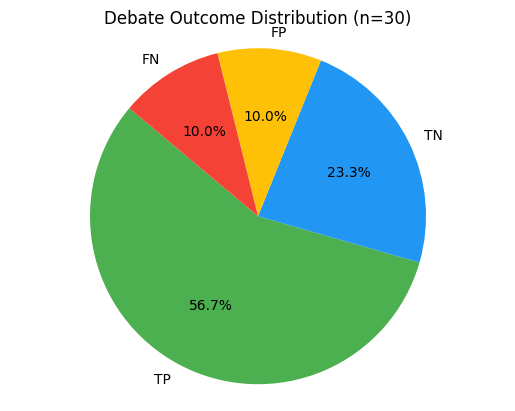

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# === Tunable Parameters ===
n_samples = 100
verbose = False

# === Outcome Counters ===
tp = tn = fp = fn = 0

# === Track outcomes for optional detailed inspection ===
outcomes = []

# === Run Mock Trial on n_samples ===
for i in range(n_samples):
    row = test_df.sample(1).iloc[0]

    # Run the agent system – must now return error_type (e.g. "TP", "FP", etc.)
    verdict, transaction_str, precedents, fact_report, is_judge_right, error_type = openai_iterative_debate_with_judge(
        row=row,
        train_df=train_df,
        index=index,
        scaler=scaler,
        model=model,
        numeric_cols=numeric_cols,
        text_cols=text_cols,
        client=client,
        deployment_name=deployment_name,
        domain=domain,
        max_rounds=1,
        verbose=verbose
    )

    # Count outcomes
    if error_type == "TP":
        tp += 1
    elif error_type == "TN":
        tn += 1
    elif error_type == "FP":
        fp += 1
    elif error_type == "FN":
        fn += 1

    # Track per-case data
    truth = row.get("is_fraud", row.get("Class", row.get("insuranceclaim", "unknown")))
    is_fraud_truth = (truth == 1)
    verdict_upper = verdict.upper()
    is_fraud_pred = "NOT FRAUD" not in verdict_upper and "FRAUD" in verdict_upper

    outcomes.append({
        "outcome": error_type,
        "truth": "FRAUD" if is_fraud_truth else "NOT FRAUD",
        "verdict": "FRAUD" if is_fraud_pred else "NOT FRAUD",
        "is_correct": is_judge_right
    })

# === Results Table ===
results_df = pd.DataFrame(outcomes)
summary_df = pd.DataFrame({
    "Outcome Type": ["True Positive", "True Negative", "False Positive", "False Negative"],
    "Count": [tp, tn, fp, fn]
})

display(summary_df)

# === Plot ===
fig, ax = plt.subplots()
labels = ["TP", "TN", "FP", "FN"]
sizes = [tp, tn, fp, fn]
colors = ["#4CAF50", "#2196F3", "#FFC107", "#F44336"]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.axis('equal')
plt.title(f"Debate Outcome Distribution (n={n_samples})")
plt.show()


## 🌱 Future Directions and Tabled Ideas for Improvement

These ideas were identified as promising but intentionally deferred until a later stage of development:

- **Pattern Evidence Summary Injection:** Before the judge delivers a verdict, inject a concise, structured summary of key fraud indicators derived from precedent transactions (e.g., same cardholder, time proximity, similar amounts, geographic deviation). This provides the model with an evidence-based checklist that reinforces consistent and accurate rulings without relying solely on the quality of the debate text.

- **Hallucination Detection:** Automatically flag and analyze when the prosecutor or defender invents facts not grounded in the case.

- **Automatic Verdict Summarization:** Simplify the judge’s prose to highlight only the top 2–3 reasons for the ruling.

- **Fact-Checker Risk Score:** Create a numerical anomaly risk score based on the Fact-Checker report for statistical calibration.

- **Agent Retraining via RAG + Supervised Finetuning:** Use misclassified or high-risk cases to retrain agent behavior with reinforcement learning or distillation.

- **Agent Role Scorecarding:** Track per-agent precision/recall and use performance to guide strategic prompting or agent self-improvement.

- **Dynamic Prompt Calibration:** Automatically adjust prompt structure and verbosity to reduce LLM cutoff and hallucination risks.

- **Error-Driven Curriculum:** Weight harder, previously misclassified examples higher in future training cycles or testing.

These will be explored once the base system proves robust through initial testing and error analysis.
